In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from openslide import OpenSlide

In [30]:
plt.rcParams.update({'font.size': 25})

patch_size = 2048#1024

In [ ]:
CRC-AI-15 40X.tif
CRC-AI-15 X40.tif

In [11]:
predicted_annotations["image_name"].unique()

array(['CRC-A1-1 HE.tif', 'CRC-A1-10 HE.tif', 'CRC-A1-13 HE.tif',
       'CRC-A1-2 HE.tif', 'CRC-A1-5 HE.tif', 'CRC-AI-15 40X.tif',
       'CRC-AI-11 F X40.tif', 'CRC-AI-14 1G X40.tif',
       'CRC-AI-8 E X40.tif', 'CRC-AI-8 H X40.tif'], dtype=object)

In [4]:
slide_list = {path.name: OpenSlide(str(path)).get_thumbnail(size=(patch_size, patch_size)) for path in tqdm(Path(r"D:\Datasets\ColonCancer").glob("*/*/*.*")) 
                      if path.suffix in [".tif"]}

slide_list

20it [00:21,  1.09s/it]


{'CRC-A1-1 HE.tif': <PIL.Image.Image image mode=RGB size=983x1024 at 0x12170EE2128>,
 'CRC-A1-10 HE.tif': <PIL.Image.Image image mode=RGB size=1024x935 at 0x12170EE2240>,
 'CRC-A1-13 HE.tif': <PIL.Image.Image image mode=RGB size=1024x964 at 0x12170EE2390>,
 'CRC-A1-2 HE.tif': <PIL.Image.Image image mode=RGB size=838x1024 at 0x12170EE2470>,
 'CRC-A1-5 HE.tif': <PIL.Image.Image image mode=RGB size=741x1024 at 0x12170EE2518>,
 'CRC-A1-1.tif': <PIL.Image.Image image mode=RGB size=1024x1003 at 0x12170EE22E8>,
 'CRC-A1-10.tif': <PIL.Image.Image image mode=RGB size=1024x983 at 0x12170EE26A0>,
 'CRC-A1-13.tif': <PIL.Image.Image image mode=RGB size=814x1024 at 0x12170EE2780>,
 'CRC-A1-2.tif': <PIL.Image.Image image mode=RGB size=879x1024 at 0x12170EE2860>,
 'CRC-A1-5.tif': <PIL.Image.Image image mode=RGB size=794x1024 at 0x12170EE2940>,
 'CRC-AI-11 F X40.tif': <PIL.Image.Image image mode=RGB size=816x1024 at 0x12170EE28D0>,
 'CRC-AI-14 1G X40.tif': <PIL.Image.Image image mode=RGB size=878x1024 

In [5]:
coordinates = {
    "L0": (0, 0), 
    "L1": (1, 0), 
    "L2": (2, 0), 
    "L3": (3, 0),   
    "L4": (4, 0),
    
    "L5": (0, 1),
    "L6": (1, 1),
    "L7": (2, 1),
    "L8": (3, 1),    
    "L9": (4, 1),
    
    "L10": (0, 2),
    "L11": (1, 2),
    "L12": (2, 2),
    "L13": (3, 2),    
    "L14": (4, 2),
    
    "L15": (0, 3),
    "L16": (1, 3),
    "L17": (2, 3),
    "L18": (3, 3),    
    "L19": (4, 3),
    
    "L20": (0, 4),
    "L21": (1, 4),
    "L22": (2, 4),
    "L23": (3, 4),    
    "L24": (4, 4),
}

In [6]:
def add_help_fields(frame):
    
    frame["image_name_stem"] = [Path(image_name).stem for image_name in frame["image_name"]]
    
    frame["patient_id"] = [name.split("-")[2].replace("40X", "X40").split(" X40")[0].replace(" HE", "").replace(".tif", "") for name in frame["image_name"]]

    frame["x1"] = [json.loads(vector.replace("\'","\""))['x1'] for vector in frame["vector"]]
    frame["y1"] = [json.loads(vector.replace("\'","\""))['y1'] for vector in frame["vector"]]

    frame["x2"] = [json.loads(vector.replace("\'","\""))['x2'] for vector in frame["vector"]]
    frame["y2"] = [json.loads(vector.replace("\'","\""))['y2'] for vector in frame["vector"]]

    frame["center_x"] = [x1 + ((x2-x1) / 2) for x1, x2 in zip(frame["x1"], frame["x2"])]
    frame["center_y"] = [y1 + ((y2-y1) / 2) for y1, y2 in zip(frame["y1"], frame["y2"])]
    
    frame["center"] = [np.array((center_x, center_y)) for center_x, center_y in zip(frame["center_x"], frame["center_y"])]

    frame["anno_width"] = [x2-x1 for x1, x2 in zip(frame["x1"], frame["x2"])]
    frame["anno_height"]= [y2-y1 for y1, y2 in zip(frame["y1"], frame["y2"])]
    
    return frame

In [31]:
gt_annotations = add_help_fields(pd.read_csv("GT_D240.csv"))

predicted_annotations = add_help_fields(pd.concat([pd.read_csv(f"QuadTree_{patch_size}.csv"), pd.read_csv("GT_Registration_D240.csv")]))
predicted_annotations.head()

,scanner,image_id,image_name,image_type,image_width,image_height,vector,unique_identifier,annotation_type,type_name,...,patient_id,x1,y1,x2,y2,center_x,center_y,center,anno_width,anno_height
0,HE,335,CRC-A1-1 HE.tif,MSSC,140203,146077,"{'x1': 11412, 'x2': 11630, 'y1': 19569, 'y2': ...",d68e7b9a-d3ae-43ea-9c7c-4dcac427c588,21,L0,...,1,11412,19569,11630,19773,11521.0,19671.0,"[11521.0, 19671.0]",218,204
1,HE,335,CRC-A1-1 HE.tif,MSSC,140203,146077,"{'x1': 10816, 'x2': 11034, 'y1': 45437, 'y2': ...",0ca22054-a283-4010-bde9-ecb8482c1bd3,22,L1,...,1,10816,45437,11034,45641,10925.0,45539.0,"[10925.0, 45539.0]",218,204
2,HE,335,CRC-A1-1 HE.tif,MSSC,140203,146077,"{'x1': 9830, 'x2': 10048, 'y1': 105362, 'y2': ...",2a73c263-0dae-4151-82e0-c661ad26930c,24,L3,...,1,9830,105362,10048,105566,9939.0,105464.0,"[9939.0, 105464.0]",218,204
3,HE,335,CRC-A1-1 HE.tif,MSSC,140203,146077,"{'x1': 12558, 'x2': 12776, 'y1': 130935, 'y2':...",0b4c38dd-b8a5-49bb-b0be-735b43e47cac,25,L4,...,1,12558,130935,12776,131139,12667.0,131037.0,"[12667.0, 131037.0]",218,204
4,HE,335,CRC-A1-1 HE.tif,MSSC,140203,146077,"{'x1': 40622, 'x2': 40840, 'y1': 18528, 'y2': ...",325de832-a522-4d95-ab15-d5748eaba0fa,26,L5,...,1,40622,18528,40840,18732,40731.0,18630.0,"[40731.0, 18630.0]",218,204


In [32]:
predicted_annotations["method"].unique()

array(['QTree_L0', 'QTree_L1', 'QTree_L2', 'GT_Registration'],
      dtype=object)

In [33]:
results = []

for image_name in predicted_annotations["image_name"].unique():
    
    gt_annotations_image = gt_annotations[gt_annotations["image_name"] == image_name]
    predicted_annotations_image = predicted_annotations[predicted_annotations["image_name"] == image_name]
    
    for method in predicted_annotations_image["method"].unique():
        
        method_annos = predicted_annotations_image[predicted_annotations_image["method"] == method]
        
        for type_name in gt_annotations_image["type_name"].unique():

            gt_anno = gt_annotations_image[gt_annotations_image["type_name"] == type_name].iloc[0]     
            predicted_anno = method_annos[method_annos["type_name"] == type_name].iloc[0]

            distance = np.linalg.norm(gt_anno.center-predicted_anno.center)

            temp_image_name = image_name.replace("40X", "X40")
            x_start = gt_anno.center_x / gt_anno.image_width * slide_list[temp_image_name].width
            x_end = predicted_anno.center_x / predicted_anno.image_width * slide_list[temp_image_name].width
            y_start = gt_anno.center_y / gt_anno.image_height * slide_list[temp_image_name].height
            y_end = predicted_anno.center_y / predicted_anno.image_height * slide_list[temp_image_name].height


            grid_x, grid_y = coordinates[gt_anno.type_name]

            row = [gt_anno.scanner, image_name, gt_anno.image_type, gt_anno.annotation_type, 
                   gt_anno.type_name, gt_anno.patient_id, distance, grid_x, grid_y,
                  x_start, x_end, y_start, y_end, method]
            results.append(row)

results = pd.DataFrame(results, columns=["scanner", "image_name", "image_type", "annotation_type", 
                                         "type_name", "patient_id", "distance", "grid_x", "grid_y",
                                        "x_start", "x_end", "y_start", "y_end", "method"])
results.head()

,scanner,image_name,image_type,annotation_type,type_name,patient_id,distance,grid_x,grid_y,x_start,x_end,y_start,y_end,method
0,HE,CRC-A1-1 HE.tif,MSSC,21,L0,1,746.089807,0,0,82.817030,80.776752,133.077870,137.893741,QTree_L0
1,HE,CRC-A1-1 HE.tif,MSSC,22,L1,1,1235.382532,1,0,74.627875,76.598040,310.795430,319.228462,QTree_L0
2,HE,CRC-A1-1 HE.tif,MSSC,24,L3,1,488.802619,3,0,73.106431,69.684935,739.499086,739.302806,QTree_L0
3,HE,CRC-A1-1 HE.tif,MSSC,25,L4,1,926.206241,4,0,94.021027,88.811659,922.446107,918.569576,QTree_L0
4,HE,CRC-A1-1 HE.tif,MSSC,26,L5,1,862.645350,0,1,279.889589,285.575722,128.535389,130.596329,QTree_L0


In [34]:
method_comparision = []

for image_type in results["image_type"].unique():
    for method in results["method"].unique():
        for type_name in results["type_name"].unique():
            for scanner in results["scanner"].unique():
            
                df = results[(results["image_type"] == image_type) & 
                             (results["method"] == method) & 
                             (results["type_name"] == type_name) & 
                             (results["scanner"] == scanner)]

                if df.empty == False:
                    sum_dist = df["distance"].median()

                    grid_x, grid_y = df.iloc[0].grid_x, df.iloc[0].grid_y

                    method_comparision.append([method, scanner, image_type, type_name, sum_dist, grid_x, grid_y])
method_comparision = pd.DataFrame(method_comparision, columns=["method", "scanner", "image_type", "type_name", 
                                                               "sum_dist", "grid_x", "grid_y"])
method_comparision.head()

,method,scanner,image_type,type_name,sum_dist,grid_x,grid_y
0,QTree_L0,HE,MSSC,L0,792.413775,0,0
1,QTree_L0,HE,MSSC,L1,1125.239539,1,0
2,QTree_L0,HE,MSSC,L3,565.106185,3,0
3,QTree_L0,HE,MSSC,L4,3813.839047,4,0
4,QTree_L0,HE,MSSC,L5,1019.817577,0,1


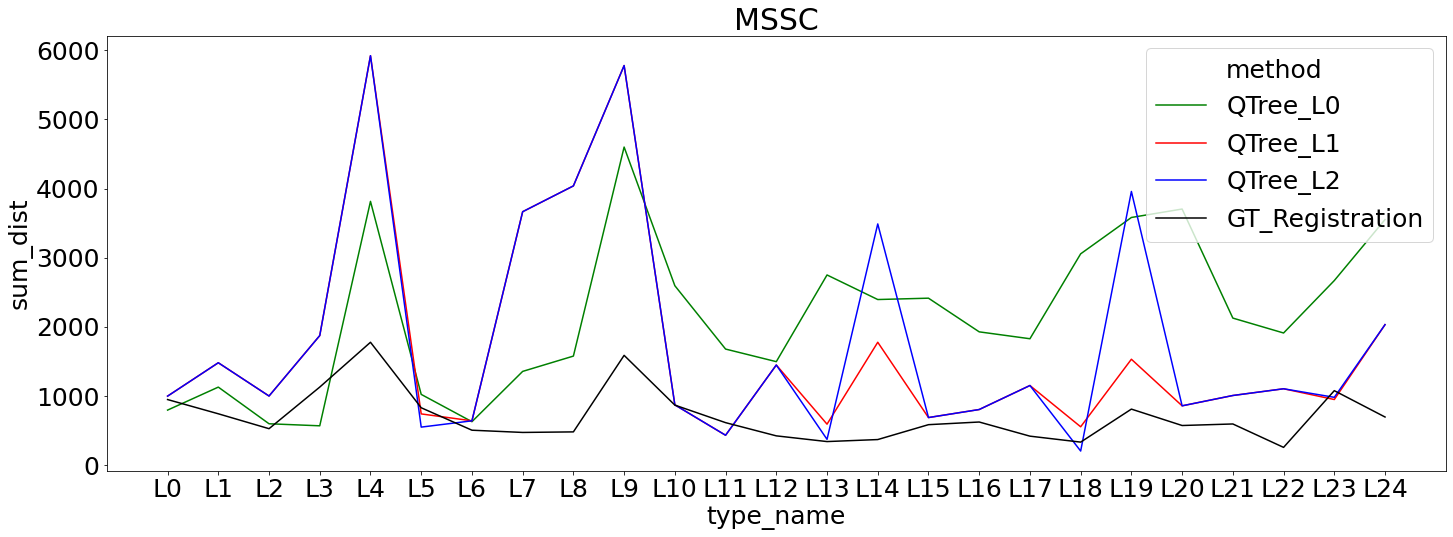

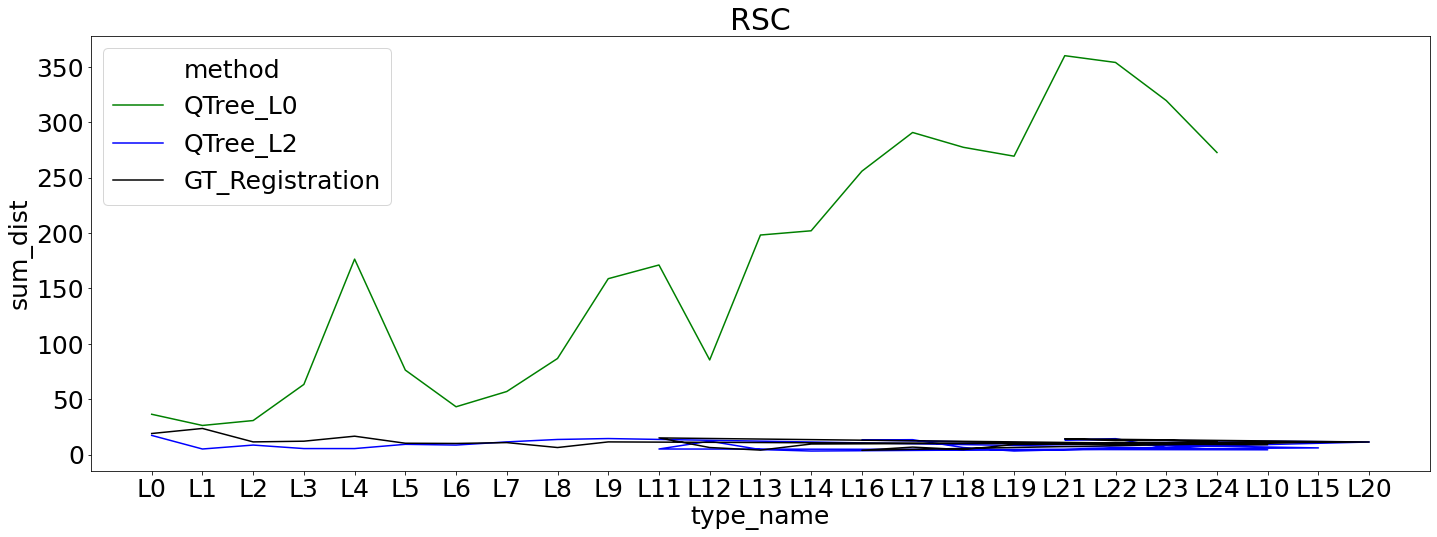

In [35]:
palette ={"QTree_L0": "g", "QTree_L1": "r", "QTree_L2": "b", "GT_Registration": "k"}

#plot_order = image_type_data.sort_values(by=["grid_x", "grid_y"]).index

for image_type in method_comparision["image_type"].unique():
    
    image_type_data = method_comparision[method_comparision["image_type"] == image_type]
    
    fig, ax = plt.subplots(figsize=(24, 8))

    ax.set_title(f"{image_type_data.iloc[0].image_type}")
    sns.lineplot(x="type_name", y="sum_dist",
                 hue="method",  #scanner
                 #style="method",
                 data=image_type_data.sort_values(by=["grid_y", "grid_x"]), ax=ax, palette=palette, sort=False)

    plt.legend() # bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.
    plt.savefig(f'TypeNames_{image_type}.pdf')  
    
    plt.show()
    
    


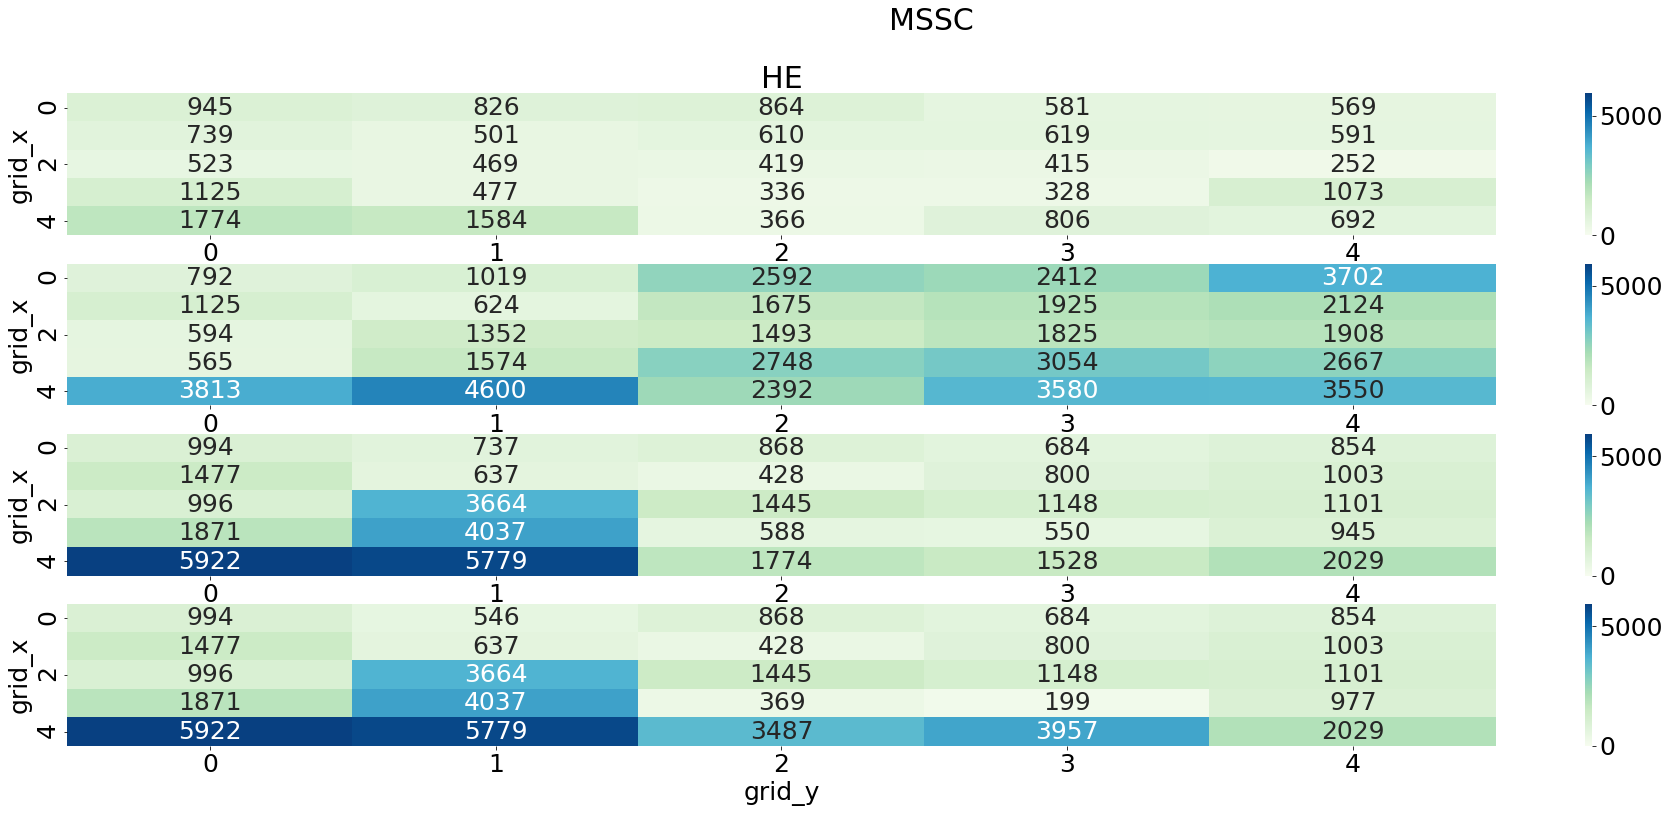

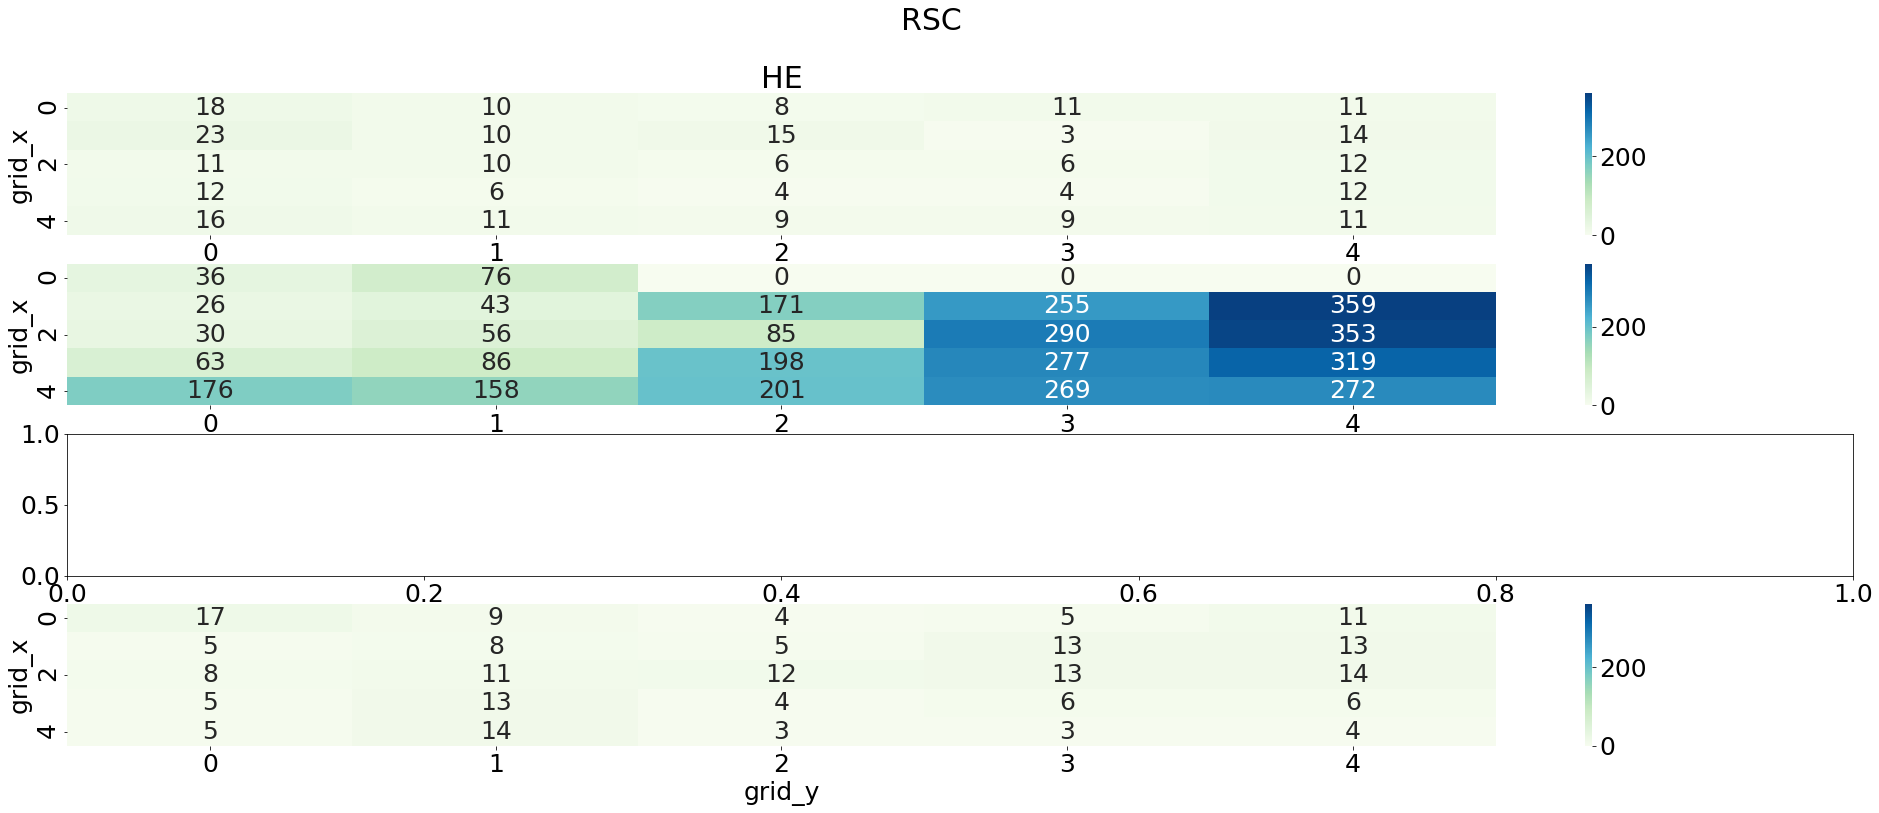

In [36]:
for image_type in method_comparision["image_type"].unique():
    
    image_type_data = method_comparision[method_comparision["image_type"] == image_type]
    
    max_distance = max(image_type_data["sum_dist"])
    
    fig, (ax_1, ax_2, ax_3, ax_4)  = plt.subplots(4, 1, figsize=(32, 12))
    
    fig.suptitle(f"{image_type}")
    
    for scanner, ax, method in [
                        ("HE", ax_1, "GT_Registration"),
                        ("HE", ax_2, "QTree_L0"),
                        ("HE", ax_3, "QTree_L1"),
                        ("HE", ax_4, "QTree_L2"),
                       ]:
        
        
        data = image_type_data[(image_type_data["scanner"] == scanner) & (image_type_data["method"] == method)]
        
        if data.empty == False:
            if method == "GT_Registration":
                ax.set_title(f"{data.iloc[0].scanner}")

            sns.heatmap(data.pivot("grid_x", "grid_y", "sum_dist").replace(np.nan, 0).astype(int), 
                    ax=ax, annot=True, cmap="GnBu", fmt="d", vmin=0, vmax=max_distance)

            if scanner == "S210":
                ax.set_ylabel(method)
        
    plt.show()

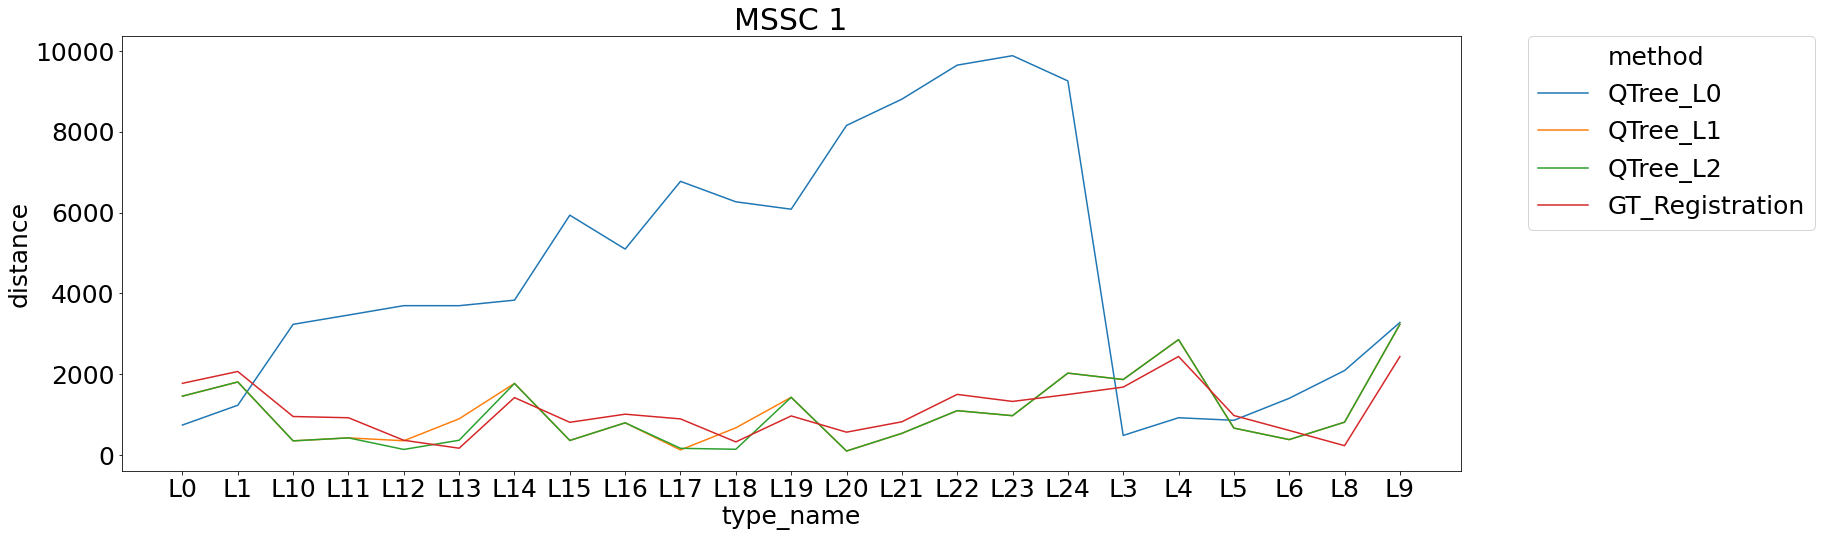

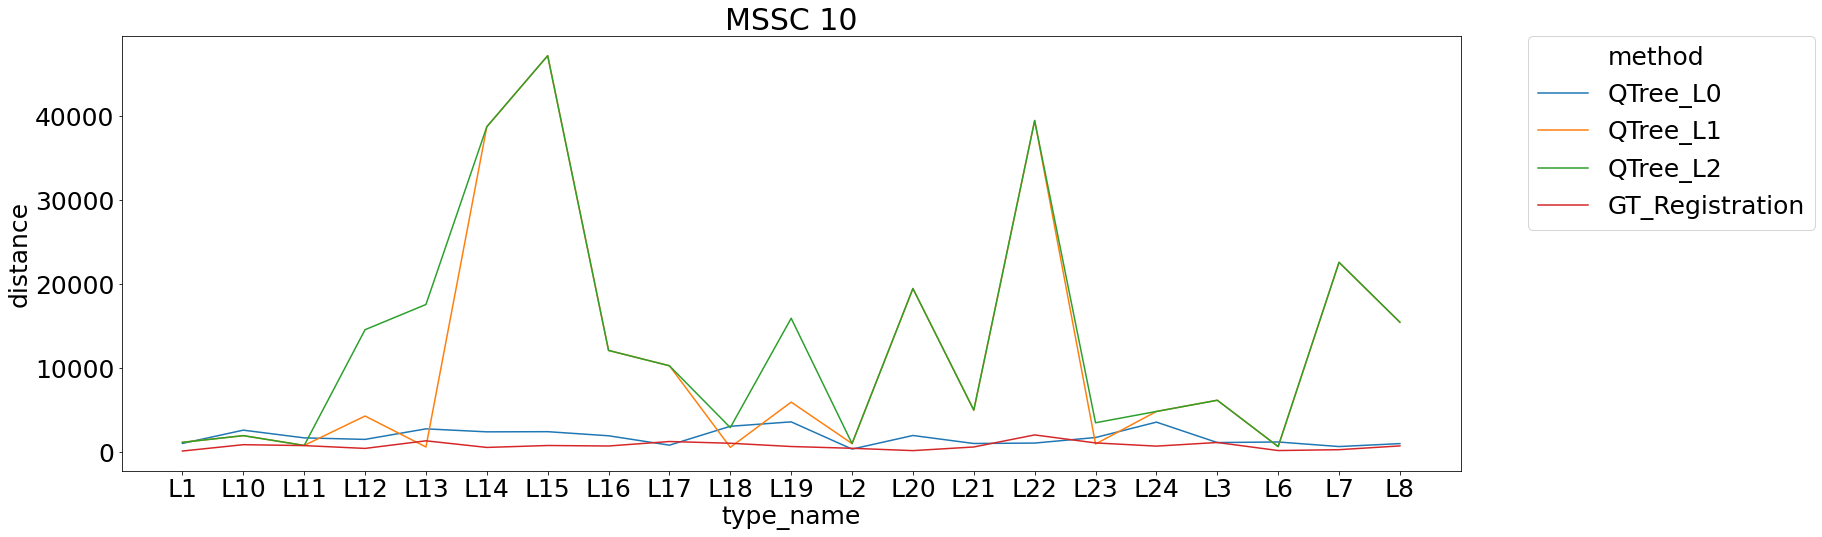

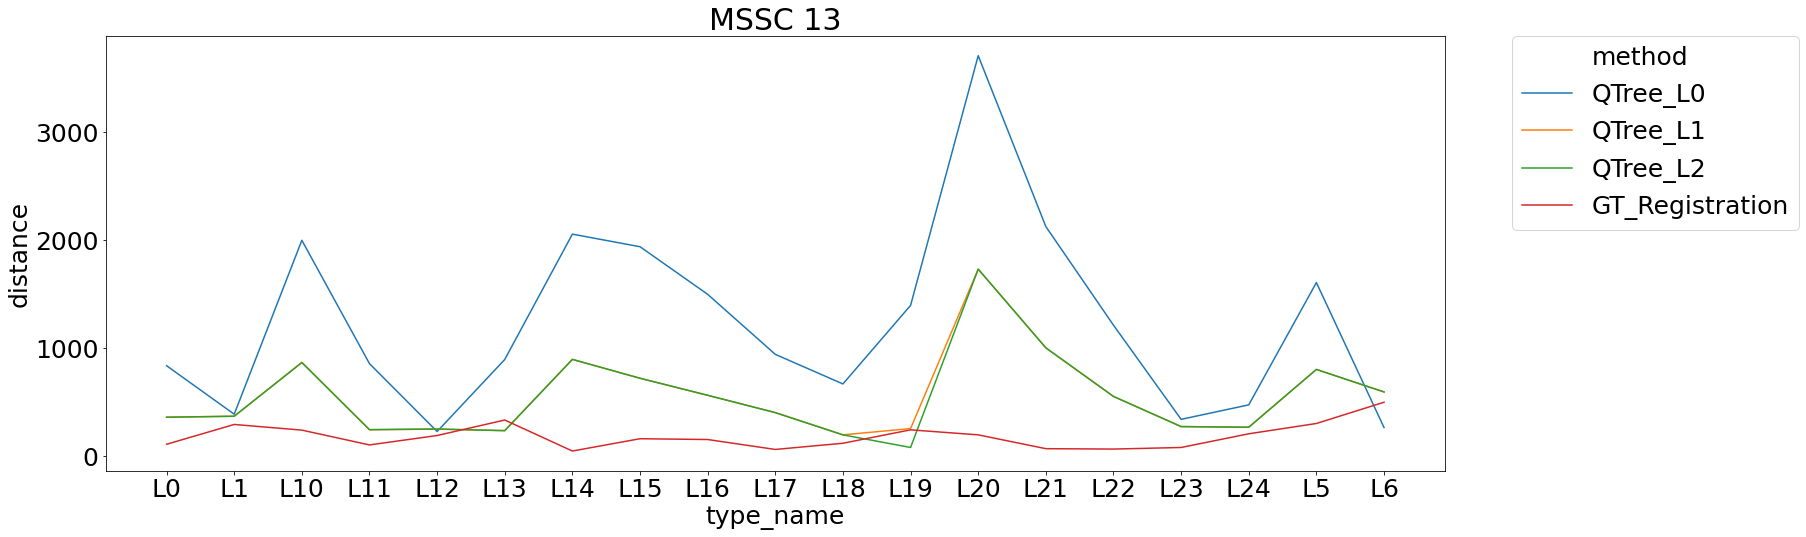

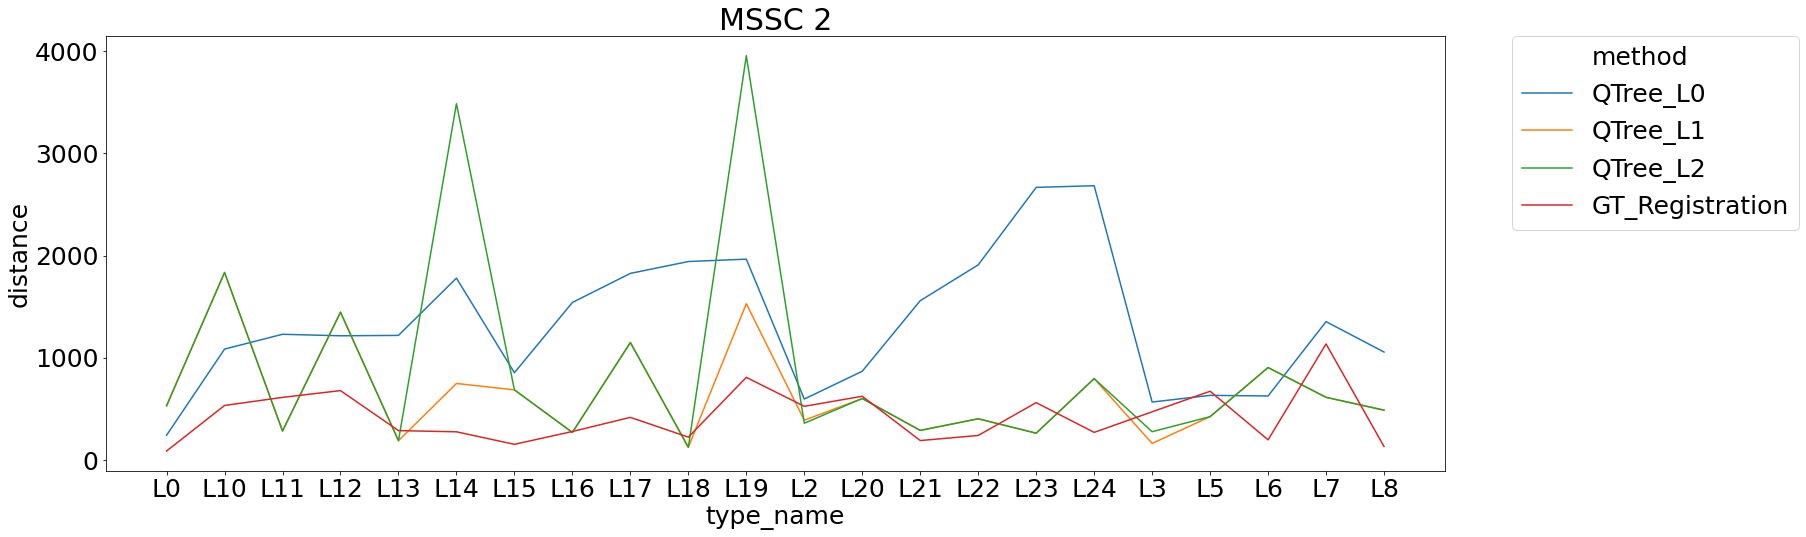

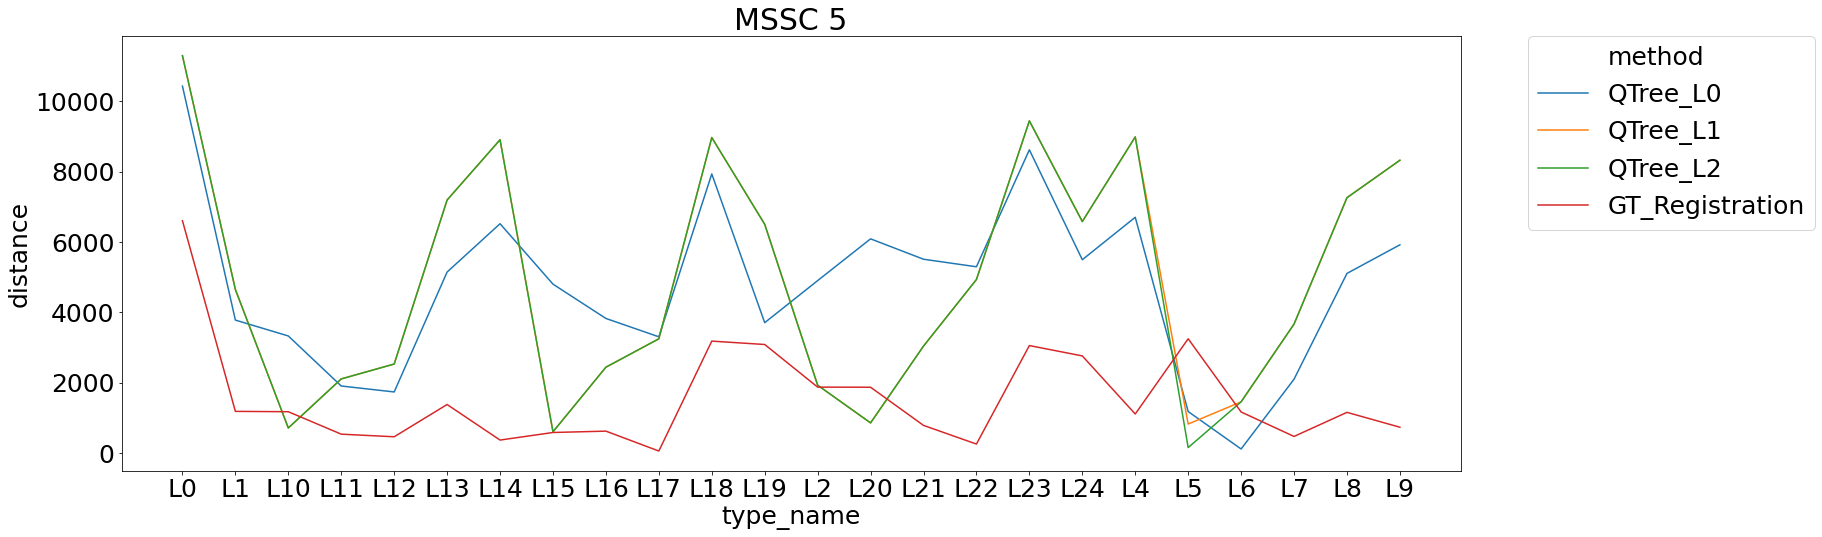

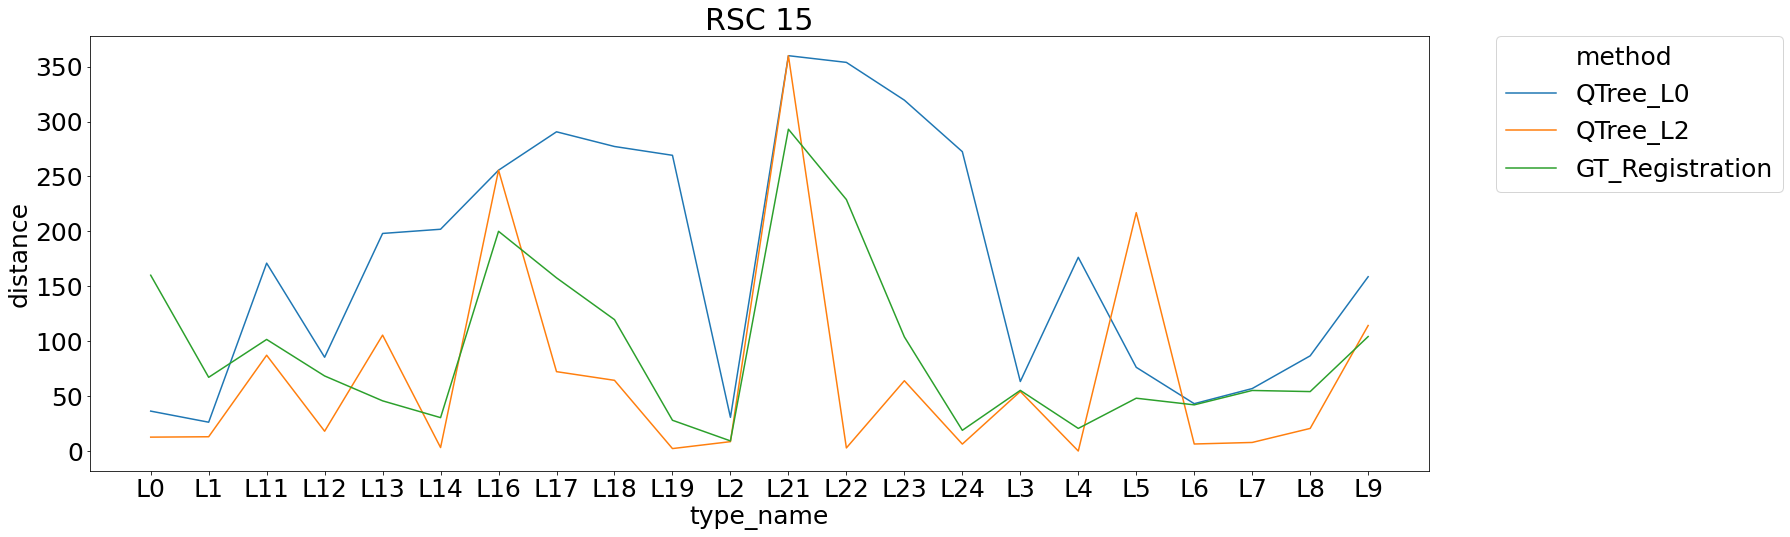

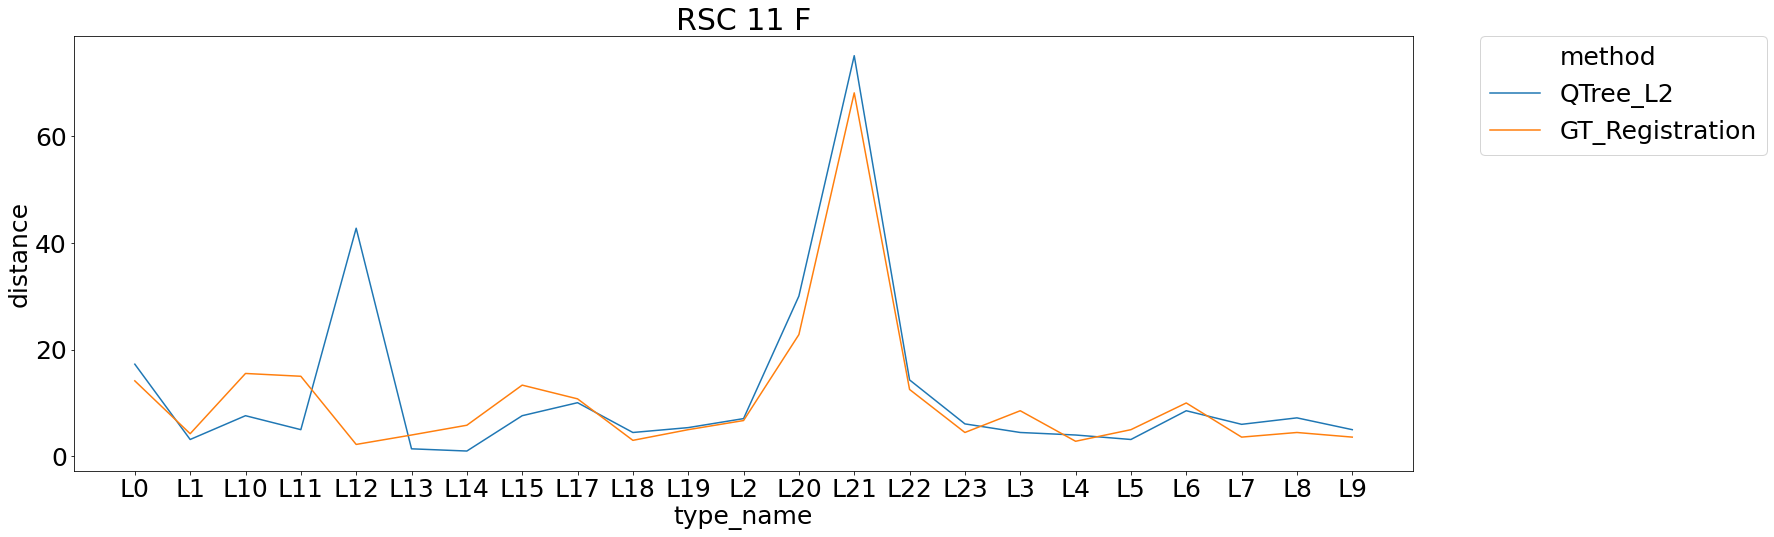

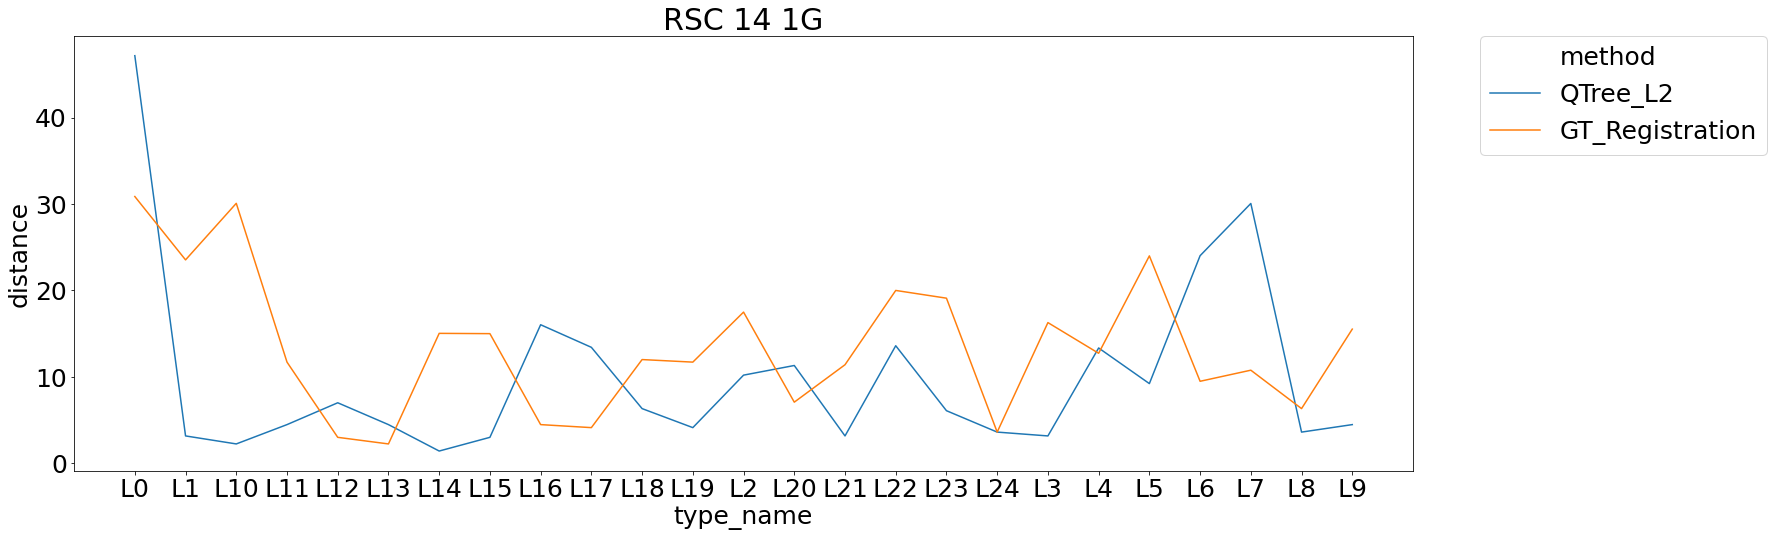

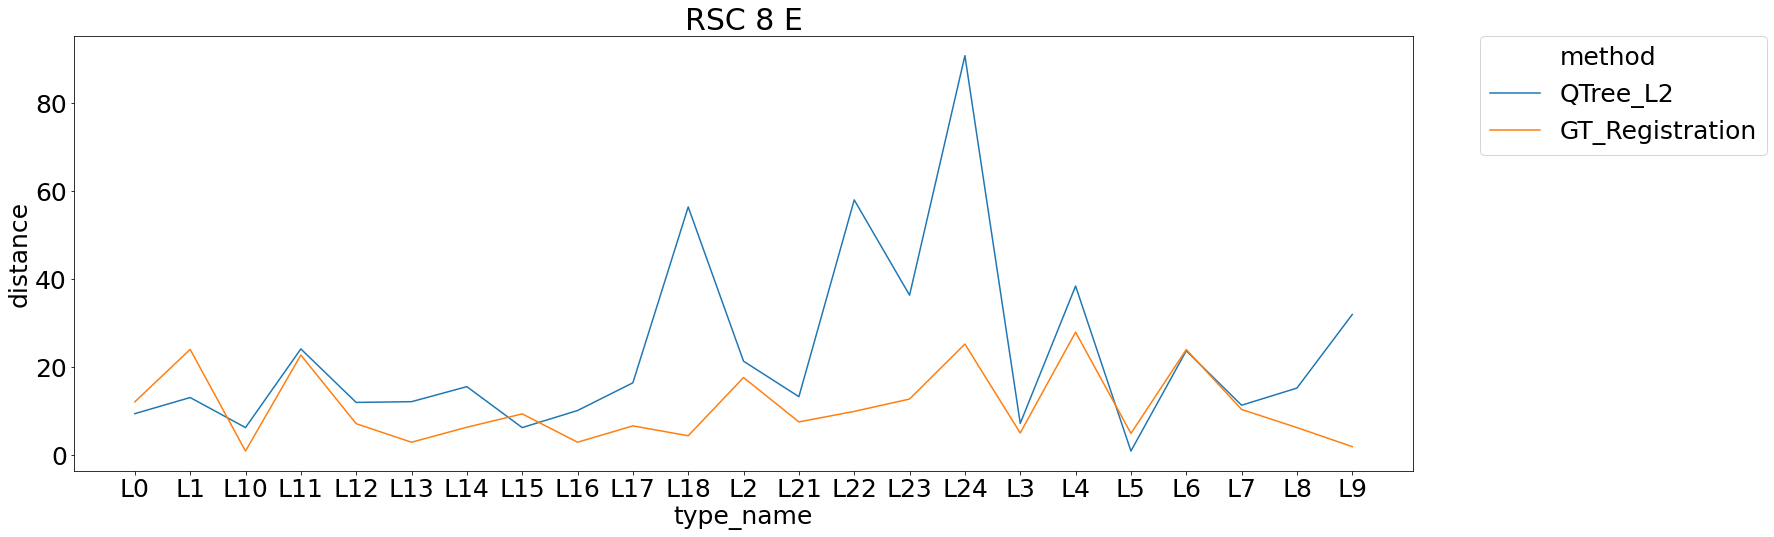

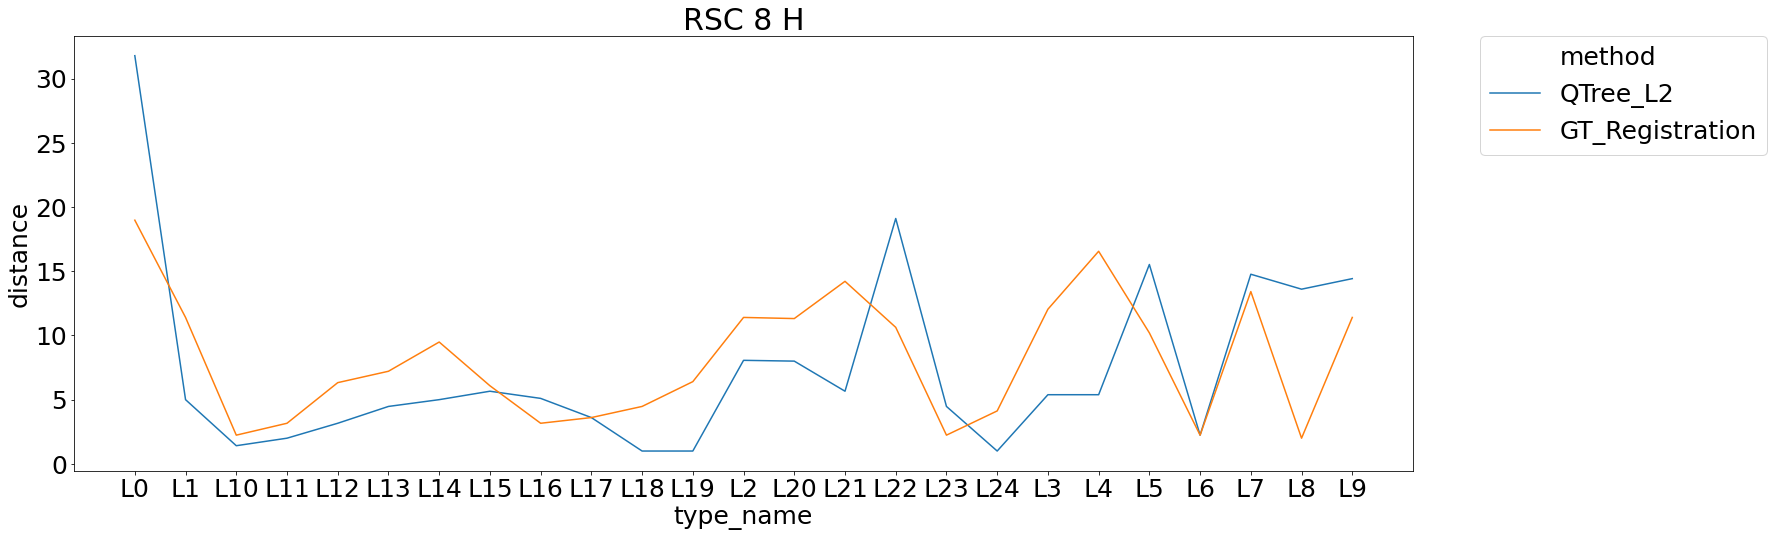

In [37]:
for patient_id in results["patient_id"].unique():
    
    patient_data = results[results["patient_id"] == patient_id]
    
    fig, ax = plt.subplots(figsize=(24, 8))
    
    ax.set_title(f"{patient_data.iloc[0].image_type} {patient_id}")
    sns.lineplot(x="type_name", y="distance",
             hue="method",  #scanner
             #style="method",
             data=patient_data, ax=ax)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    

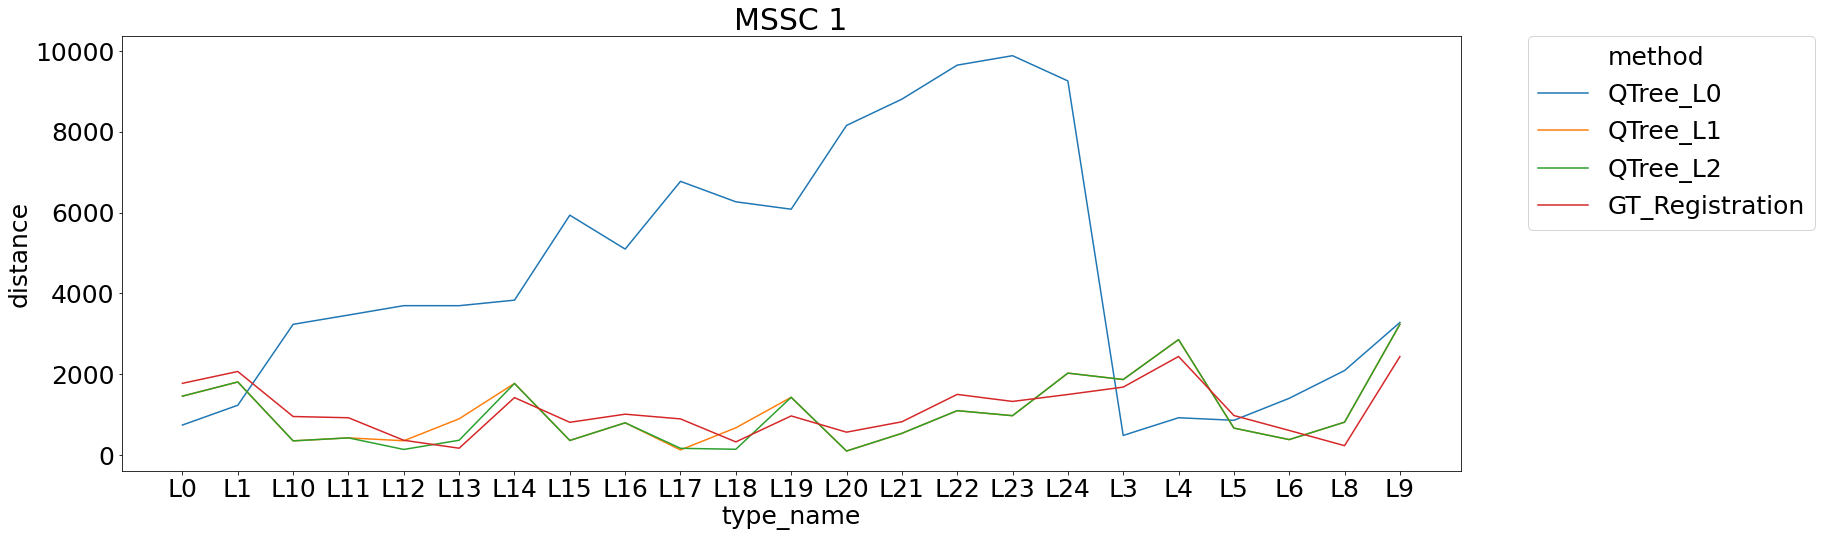

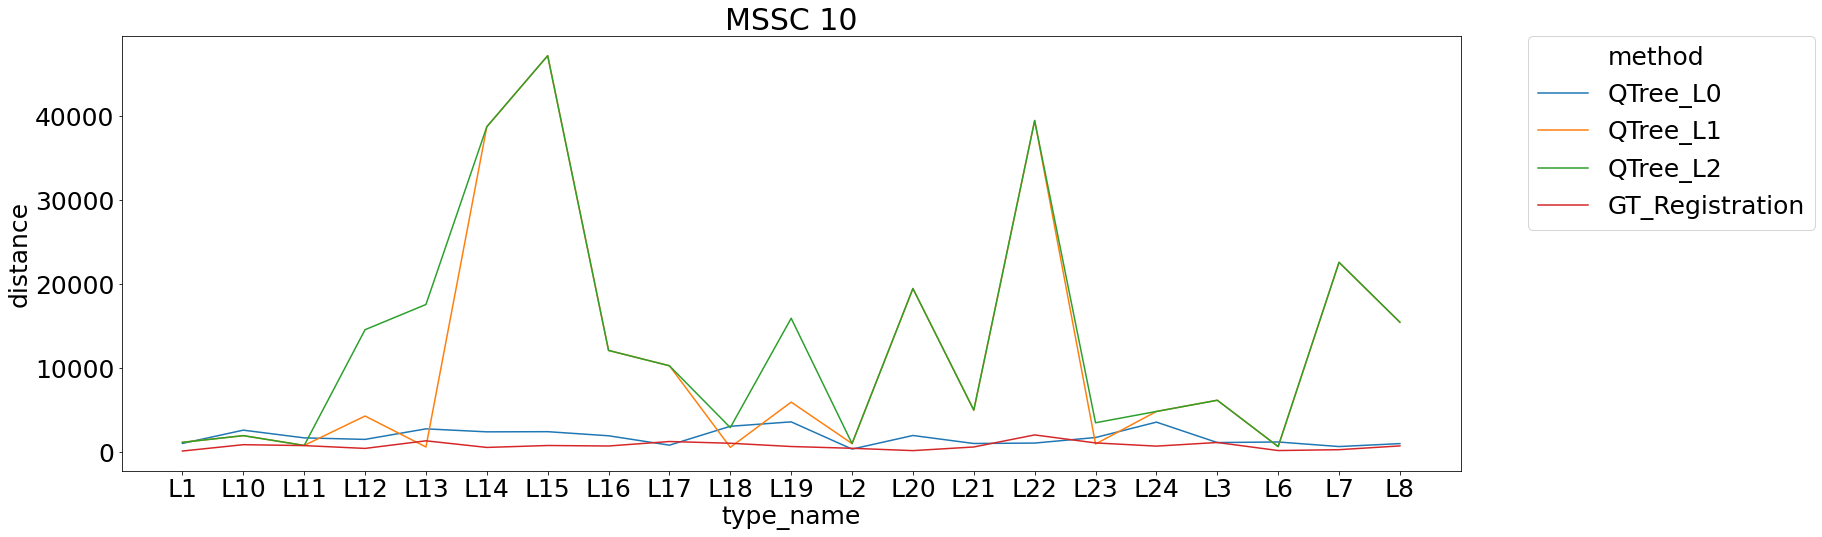

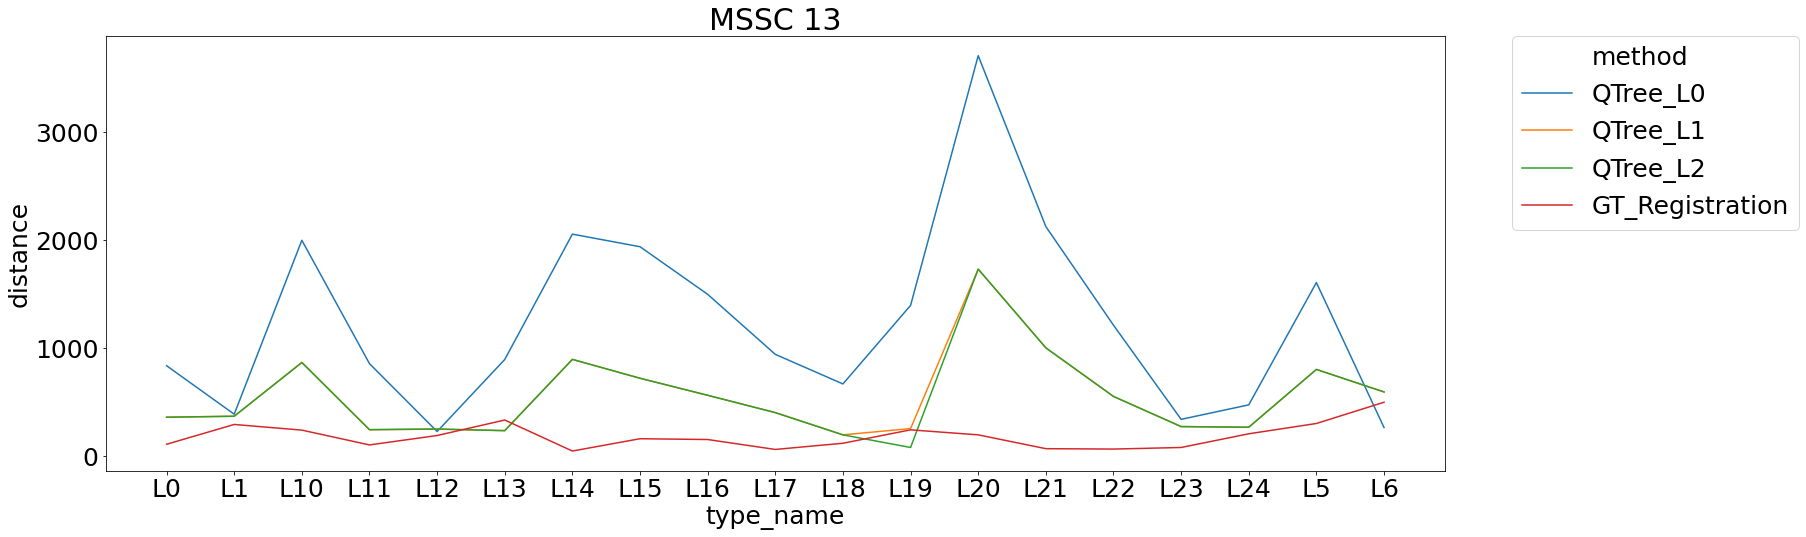

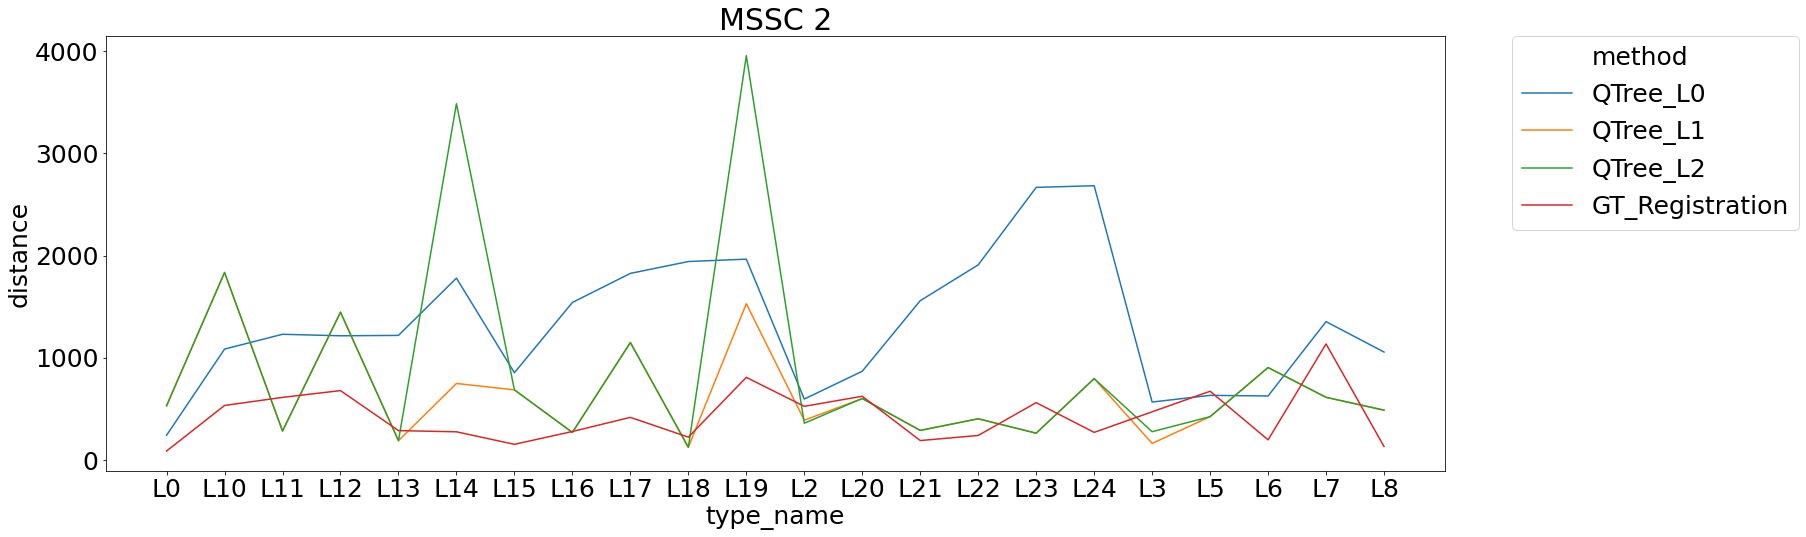

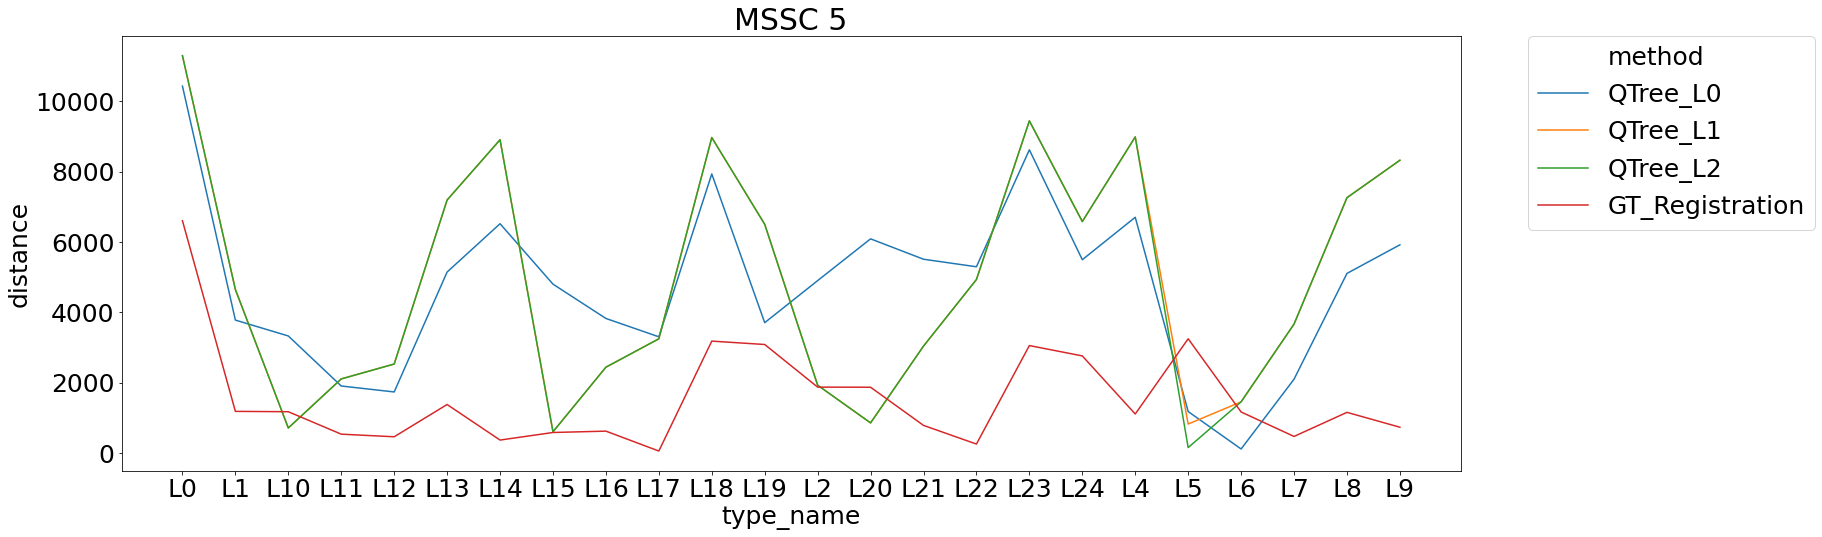

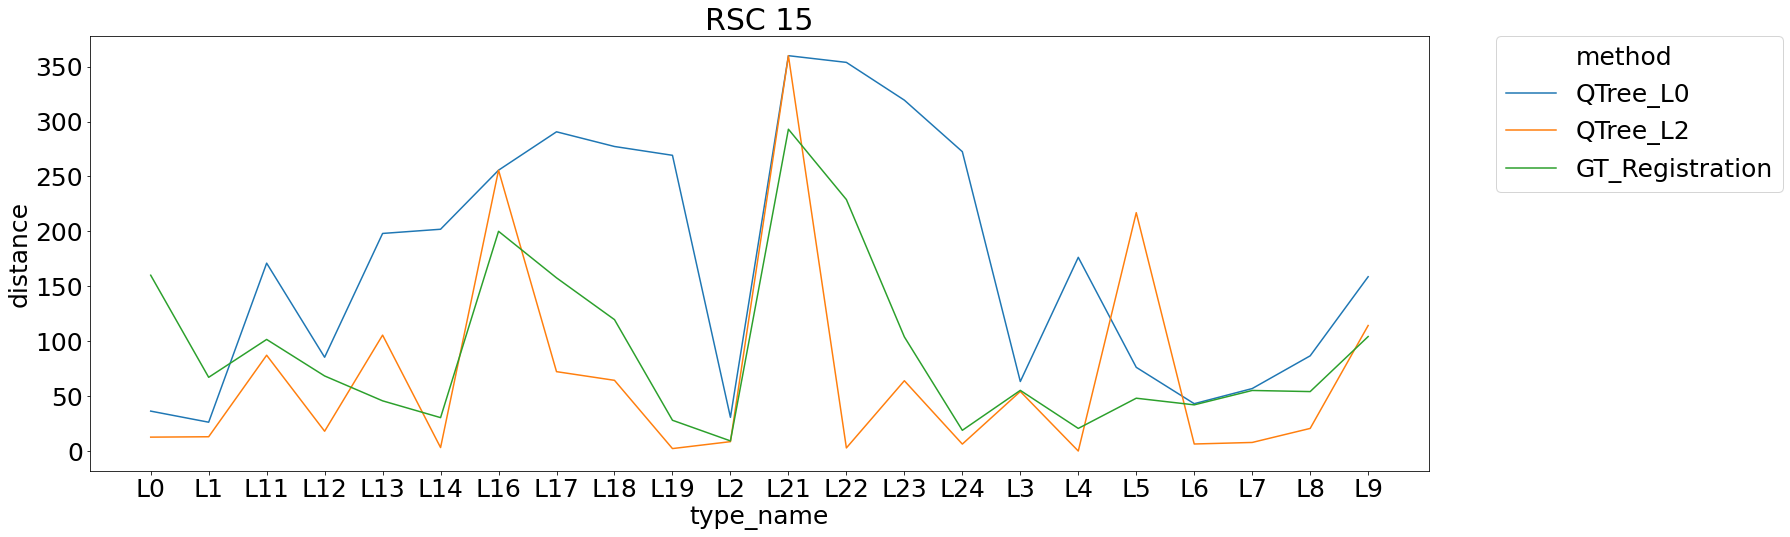

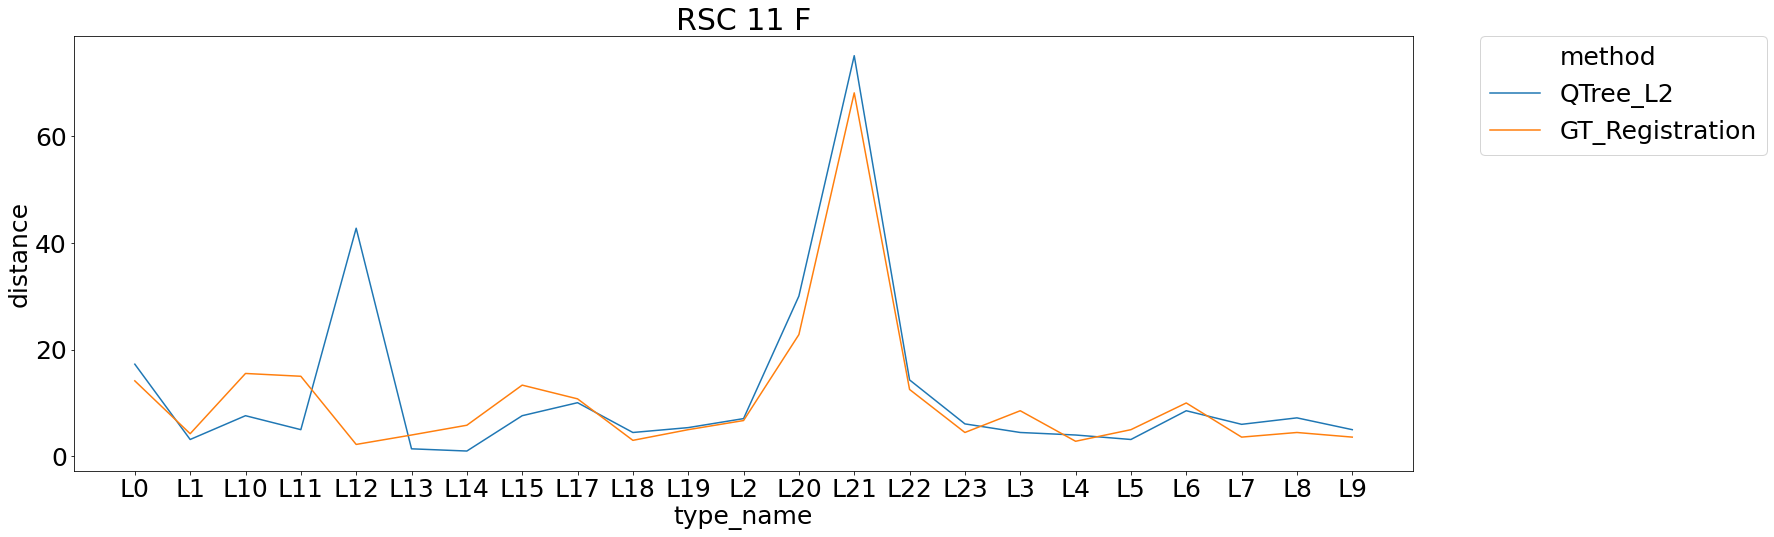

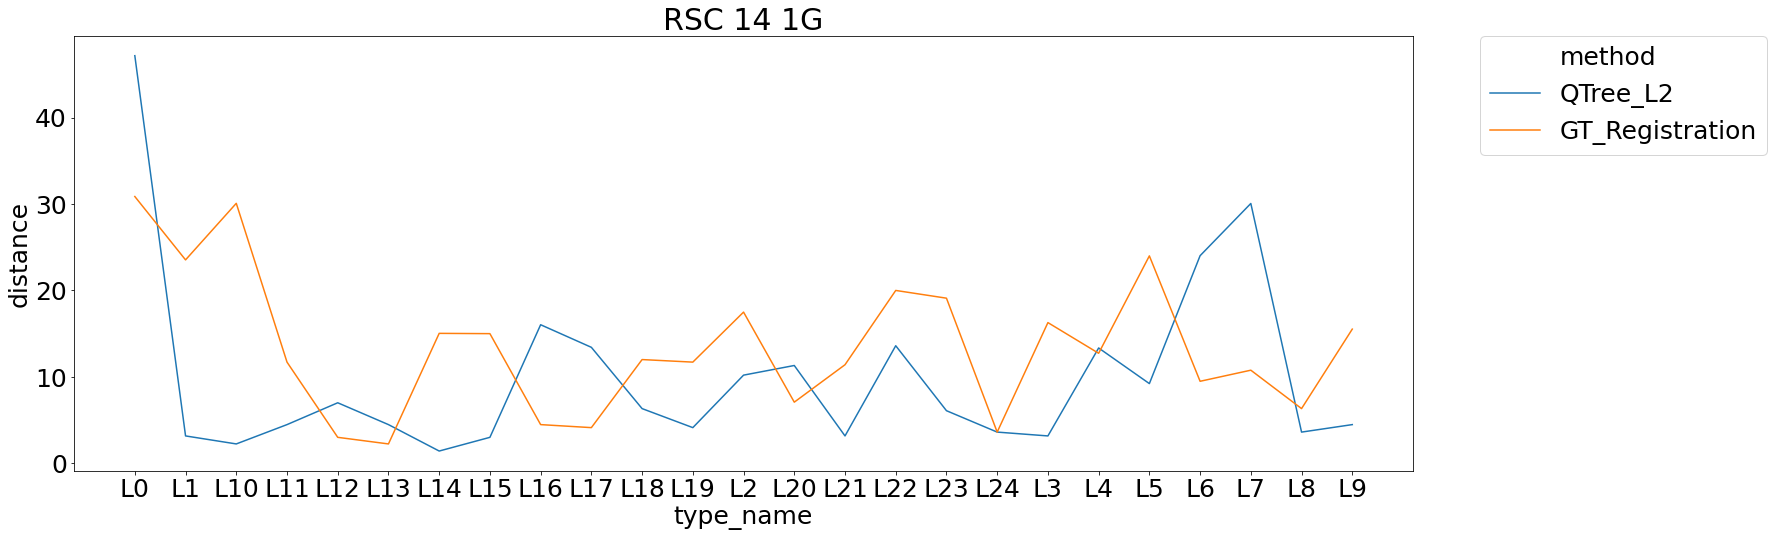

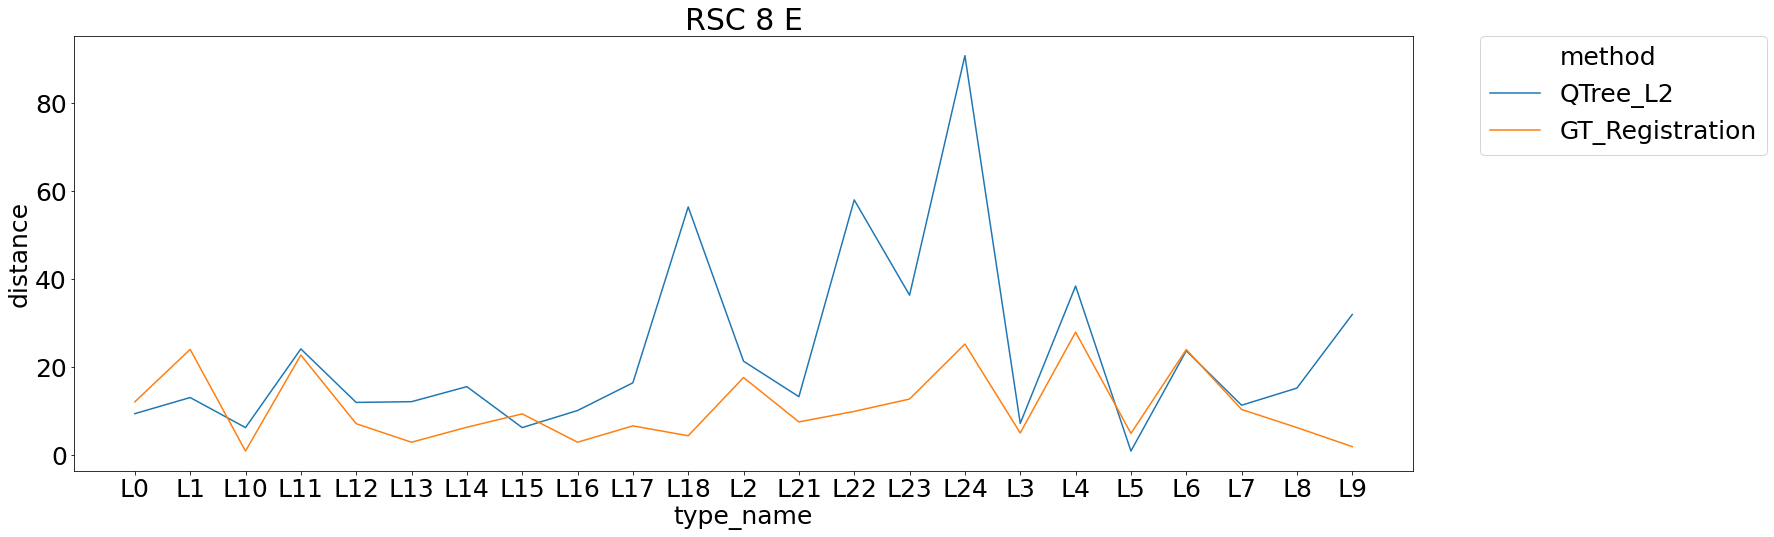

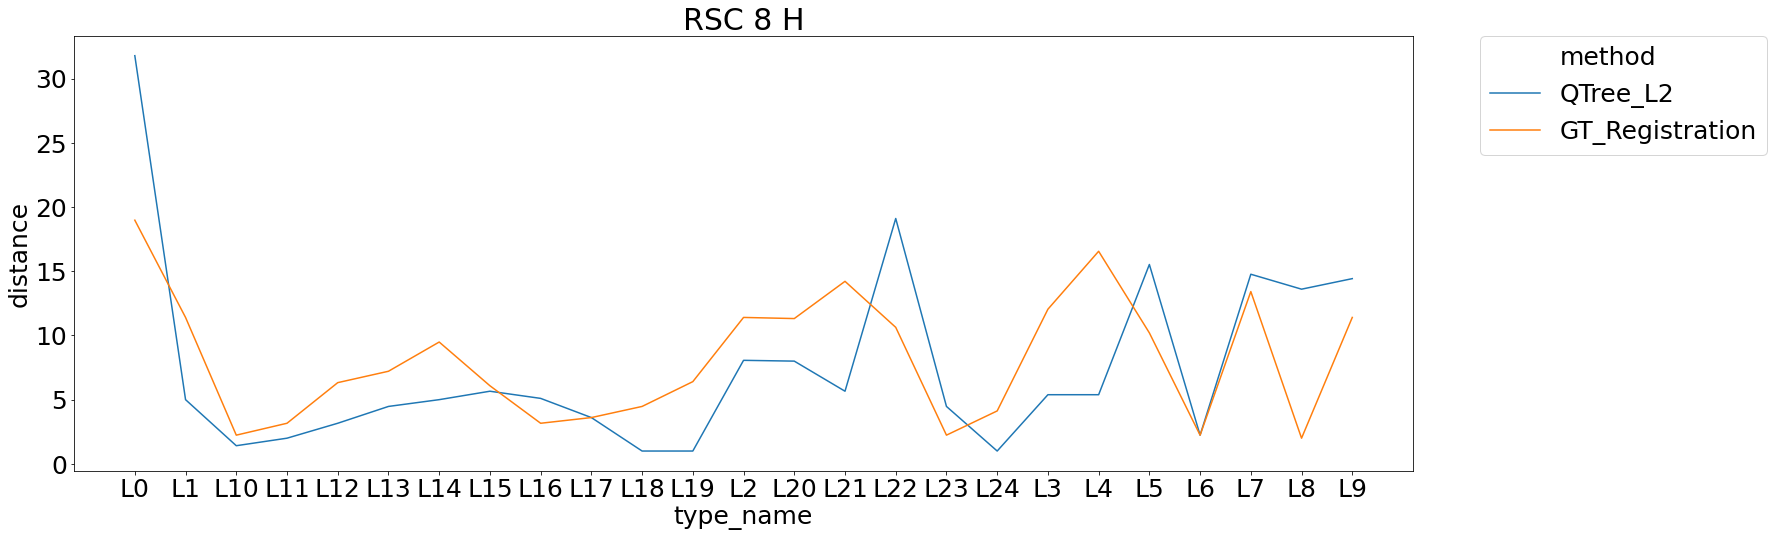

In [38]:
for patient_id in results["patient_id"].unique():
    
    patient_data = results[results["patient_id"] == patient_id]
    
    fig, ax = plt.subplots(figsize=(24, 8))
    
    ax.set_title(f"{patient_data.iloc[0].image_type} {patient_id}")
    sns.lineplot(x="type_name", y="distance",
             hue="method",  #scanner
             #style="method",
             data=patient_data, ax=ax)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    